# **Librerias**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
import datetime
import io

pysqldf = lambda q: sqldf(q, globals())

# **Data**

In [2]:
dat = pd.read_csv("tabla_completa.csv",encoding="latin")
print(dat.shape,"\n")
dat.head()

(2180, 11) 



,Unnamed: 0,COD_VIAJE,CLIENTE,UBICACION,CANTIDAD,PILOTO,Q,CREDITO,UNIDAD,MES,ANIO
0,1,10000001,EL PINCHE OBELISCO / Despacho a cliente,76002,1200,Fernando Mariano Berrio,300.00,30,Camion Grande,1,2019
1,2,10000002,TAQUERIA EL CHINITO |||Faltante,76002,1433,Hector Aragones Frutos,358.25,90,Camion Grande,1,2019
2,3,10000003,TIENDA LA BENDICION / Despacho a cliente,76002,1857,Pedro Alvarez Parejo,464.25,60,Camion Grande,1,2019
3,4,10000004,TAQUERIA EL CHINITO,76002,339,Angel Valdez Alegria,84.75,30,Panel,1,2019
4,5,10000005,CHICHARRONERIA EL RICO COLESTEROL |||Faltante,76001,1644,Juan Francisco Portillo Gomez,411.00,30,Camion Grande,1,2019


In [3]:
dat.drop(columns=["Unnamed: 0"],inplace=True) # ID

In [4]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2180 entries, 0 to 2179
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   COD_VIAJE  2180 non-null   int64  
 1   CLIENTE    2180 non-null   object 
 2   UBICACION  2180 non-null   int64  
 3   CANTIDAD   2180 non-null   int64  
 4   PILOTO     2180 non-null   object 
 5   Q          2180 non-null   float64
 6   CREDITO    2180 non-null   int64  
 7   UNIDAD     2180 non-null   object 
 8   MES        2180 non-null   int64  
 9   ANIO       2180 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 170.4+ KB


In [5]:
dat.isnull().sum()

COD_VIAJE    0
CLIENTE      0
UBICACION    0
CANTIDAD     0
PILOTO       0
Q            0
CREDITO      0
UNIDAD       0
MES          0
ANIO         0
dtype: int64

Todas las columnas vienen completas (sin NULLS)

In [6]:
dat.columns = [str.strip(str.lower(col)) for col in dat.columns.to_list()] # Columnas en minusc. y sin espacios (left o right)
dat.head()

,cod_viaje,cliente,ubicacion,cantidad,piloto,q,credito,unidad,mes,anio
0,10000001,EL PINCHE OBELISCO / Despacho a cliente,76002,1200,Fernando Mariano Berrio,300.00,30,Camion Grande,1,2019
1,10000002,TAQUERIA EL CHINITO |||Faltante,76002,1433,Hector Aragones Frutos,358.25,90,Camion Grande,1,2019
2,10000003,TIENDA LA BENDICION / Despacho a cliente,76002,1857,Pedro Alvarez Parejo,464.25,60,Camion Grande,1,2019
3,10000004,TAQUERIA EL CHINITO,76002,339,Angel Valdez Alegria,84.75,30,Panel,1,2019
4,10000005,CHICHARRONERIA EL RICO COLESTEROL |||Faltante,76001,1644,Juan Francisco Portillo Gomez,411.00,30,Camion Grande,1,2019


In [7]:
def to_date(df):
    date = datetime.date(df["anio"],df["mes"],1)
    return date

dat["date"] = dat[["mes","anio"]].apply(to_date,axis=1)
dat["mes_anio"] = dat["date"].apply(lambda x: x.strftime("%m-%Y"))
dat[["mes","anio","date","mes_anio"]]

,mes,anio,date,mes_anio
0,1,2019,2019-01-01,01-2019
1,1,2019,2019-01-01,01-2019
2,1,2019,2019-01-01,01-2019
3,1,2019,2019-01-01,01-2019
4,1,2019,2019-01-01,01-2019
...,...,...,...,...
2175,11,2019,2019-11-01,11-2019
2176,11,2019,2019-11-01,11-2019
2177,11,2019,2019-11-01,11-2019
2178,11,2019,2019-11-01,11-2019


In [8]:
dat["cliente_clean"] = dat.cliente.apply(lambda x: x.split("|||")[0].split("/")[0].strip())

Corrigiendo por las devoluciones de El Gallo Negro. Estas son devoluciones. No representan ventas.

In [9]:
dat["q_corregido"] = (dat.cliente.str.contains("DEVOLUCION")*(-2)*dat.q + dat.q)

In [10]:
credito_dict = {
    30:pd.offsets.MonthBegin(1),
    60:pd.offsets.MonthBegin(2),
    90:pd.offsets.MonthBegin(3)
}

dat["credito_dt"] = dat.credito.apply(lambda x: credito_dict[x])
dat["cobro"] =dat["date"]+dat["credito_dt"]
dat["cobro_mes_anio"] = dat["cobro"].apply(lambda x: x.strftime("%m-%Y"))
dat.drop(columns="credito_dt",inplace=True)
dat[["q","credito","date","cobro","cobro_mes_anio"]]

,q,credito,date,cobro,cobro_mes_anio
0,300.00,30,2019-01-01,2019-02-01,02-2019
1,358.25,90,2019-01-01,2019-04-01,04-2019
2,464.25,60,2019-01-01,2019-03-01,03-2019
3,84.75,30,2019-01-01,2019-02-01,02-2019
4,411.00,30,2019-01-01,2019-02-01,02-2019
...,...,...,...,...,...
2175,202.00,90,2019-11-01,2020-02-01,02-2020
2176,248.75,60,2019-11-01,2020-01-01,01-2020
2177,435.75,90,2019-11-01,2020-02-01,02-2020
2178,220.75,90,2019-11-01,2020-02-01,02-2020


In [11]:
# dat.to_csv("tabla_completa_clean.csv",index=False)

# **EDA**

## Codigo Viaje

In [9]:
dat.cod_viaje.nunique() # 

2180

El codigo del viaje es unico

## Clientes

In [34]:
dat.cliente.nunique()

18

Tengo 18 descripciones de clientes distintas.

In [37]:
list(dat.cliente.unique())

['EL PINCHE OBELISCO / Despacho a cliente',
 'TAQUERIA EL CHINITO |||Faltante',
 'TIENDA LA BENDICION / Despacho a cliente',
 'TAQUERIA EL CHINITO',
 'CHICHARRONERIA EL RICO COLESTEROL |||Faltante',
 'UBIQUO LABS |||FALTANTE',
 'EL GALLO NEGRO |||DEVOLUCION',
 'EL GALLO NEGRO / Despacho a cliente',
 'UNIVERSIDAD FRANCISCO MARROQUIN/Despacho a cliente',
 'POLLO PINULITO|||FALTANTE',
 'SPORTA, S.A./Despacho a cliente |||Faltante',
 'HOSPITAL ROOSEVELT / Despacho a cliente',
 'UBIQUO LABS',
 'BAR LA OFICINA',
 'ABARROTERIA EBENEZER/Despacho a cliente',
 'EL PINCHE OBELISCO |||Faltante',
 'POLLO PINULITO/Despacho a cliente',
 'HOSPITAL LAS AMERICAS']

Algunas empresas se repiten pero cambia el motivo (?)

In [11]:
dat.cliente_clean.nunique()

13

In [14]:
list(dat.cliente_clean.unique())

['EL PINCHE OBELISCO',
 'TAQUERIA EL CHINITO',
 'TIENDA LA BENDICION',
 'CHICHARRONERIA EL RICO COLESTEROL',
 'UBIQUO LABS',
 'EL GALLO NEGRO',
 'UNIVERSIDAD FRANCISCO MARROQUIN',
 'POLLO PINULITO',
 'SPORTA, S.A.',
 'HOSPITAL ROOSEVELT',
 'BAR LA OFICINA',
 'ABARROTERIA EBENEZER',
 'HOSPITAL LAS AMERICAS']

In [54]:
df_mejores_clientes = dat.groupby("cliente_clean",as_index=False).agg({"q_corregido":"sum"}
                                ).sort_values("q_corregido",ascending=False
                                ).rename(columns={"cliente_clean":"cliente",
                                                 "q_corregido":"ventas"})

df_mejores_clientes["porcentaje"] = round((df_mejores_clientes["ventas"]/df_mejores_clientes["ventas"].sum())*100,1)
df_mejores_clientes["porcentaje_accum"] = df_mejores_clientes.porcentaje.cumsum()
df_mejores_clientes

,cliente,ventas,porcentaje,porcentaje_accum
4,EL PINCHE OBELISCO,71079.00,13.3,13.3
9,TAQUERIA EL CHINITO,69135.50,13.0,26.3
7,POLLO PINULITO,65105.50,12.2,38.5
11,UBIQUO LABS,64250.75,12.1,50.6
12,UNIVERSIDAD FRANCISCO MARROQUIN,37889.25,7.1,57.7
0,ABARROTERIA EBENEZER,37129.00,7.0,64.7
10,TIENDA LA BENDICION,35338.00,6.6,71.3
1,BAR LA OFICINA,35163.50,6.6,77.9
8,"SPORTA, S.A.",34984.25,6.6,84.5
2,CHICHARRONERIA EL RICO COLESTEROL,32456.25,6.1,90.6


In [ ]:
df_mejores_clientes = dat.groupby("cliente_clean",as_index=False).agg({"q_corregido":"sum"}
                                ).sort_values("q_corregido",ascending=False
                                ).rename(columns={"cliente_clean":"cliente",
                                                 "q_corregido":"ventas"})

df_mejores_clientes["porcentaje"] = round((df_mejores_clientes["ventas"]/df_mejores_clientes["ventas"].sum())*100,1)
df_mejores_clientes["porcentaje_accum"] = df_mejores_clientes.porcentaje.cumsum()
df_mejores_clientes = df_mejores_clientes.head()

explode = (0.05, 0.05, 0.05, 0.05,0.05) 
# explode = (0, 0, 0, 0,0) 
colors = ["seagreen","lightgray","lightgray","lightgray","lightgray"]
# colors = ["seagreen","purple","red","blue","orange"]
fig1, ax1 = plt.subplots(figsize=(15,15))
ax1.pie(df_mejores_clientes["porcentaje"],explode=explode, labels=df_mejores_clientes["cliente"], autopct='%1.1f%%',
        shadow=True, startangle=90,colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Ubicaciones

In [41]:
print(dat.ubicacion.nunique()) # 
print(dat.ubicacion.unique())

2

Solo tengo 2 codigos de ubicaciones. Creo que esas ubicaciones son ubicaciones de las bodegas/sucursales de la distribuidora.

## Cantidad y Quetzales

Asumi que la columna "q" estaba en quetzales.

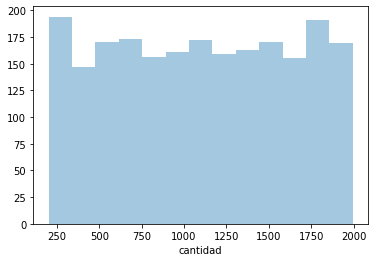

media: 1098.8
sigma: 525.95
min: 200
max: 1996


In [53]:
sns.distplot(dat.cantidad,kde=False)
plt.show()

print("media:",round(dat.cantidad.mean(),2))
print("sigma:",round(dat.cantidad.std(),2))
print("min:",round(dat.cantidad.min(),2))
print("max:",round(dat.cantidad.max(),2))

La cantidad pareciera seguir una distribución un tanto uniforme. El rango va desde 200 hasta casi 2000.

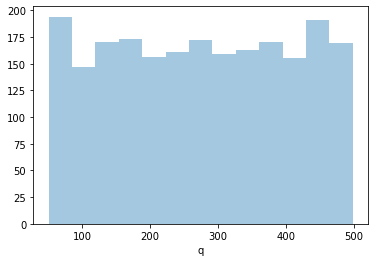

media: 274.7
sigma: 131.49
min: 50.0
max: 499.0


In [78]:
sns.distplot(dat.q,kde=False)
plt.show()

print("media:",round(dat.q.mean(),2))
print("sigma:",round(dat.q.std(),2))
print("min:",round(dat.q.min(),2))
print("max:",round(dat.q.max(),2))

La distribucion de la columna q tambien parece pertenecer a una dist. uniforme. Su rango es desde 50 a 499 (~500)

In [81]:
dat["precio_unitario"] = dat["q"]/dat["cantidad"]
print(dat.precio_unitario.nunique())
dat[["q","cantidad","precio_unitario"]].head()

1


,q,cantidad,precio_unitario
0,300.00,1200,0.25
1,358.25,1433,0.25
2,464.25,1857,0.25
3,84.75,339,0.25
4,411.00,1644,0.25


El precio para el producto que se vende es de 25 centavos

In [101]:
dat.drop(columns="precio_unitario",inplace=True) # Elimino esta col. no me sirve

In [26]:
df_devoluciones = dat[dat["cliente"]=="EL GALLO NEGRO |||DEVOLUCION"].groupby("date").agg({"q_corregido":"sum"}).rename(columns={"date":"fecha","q_corregido":"devoluciones"})
df_devoluciones["devoluciones"] = df_devoluciones["devoluciones"]*-1
df_devoluciones

,devoluciones
date,
2019-01-01,2072.50
2019-02-01,2094.25
2019-03-01,2419.25
2019-04-01,4485.50
2019-05-01,4203.00
2019-06-01,1638.75
2019-07-01,5387.75
2019-08-01,2704.75
2019-09-01,2686.75


In [44]:
# Ventas netas para El Gallo Negro (quitando el efecto de las devoluciones)
sum(dat[dat["cliente"]=="EL GALLO NEGRO / Despacho a cliente"]["q_corregido"]) + sum(dat[dat["cliente"]=="EL GALLO NEGRO |||DEVOLUCION"]["q_corregido"])

1414.5

Este cliente probablemente no esta satisfecho con nuestras tarifas o con nuestro producto.

In [45]:
dat[dat["cliente"]=="EL GALLO NEGRO |||DEVOLUCION"].groupby("piloto").agg({"q":"count"})

,q
piloto,
Angel Valdez Alegria,18
Felipe Villatoro,15
Fernando Mariano Berrio,11
Hector Aragones Frutos,17
Hector Giron,4
Ismael Rodero Monteagudo,12
Juan Francisco Portillo Gomez,7
Luis Jaime Urbano,22
Pedro Alvarez Parejo,13


## Pilotos

In [59]:
print(dat.piloto.nunique(),"pilotos distintos \n")
list(dat.piloto.unique())

9 pilotos distintos 



['Fernando Mariano Berrio',
 'Hector Aragones Frutos',
 'Pedro Alvarez Parejo',
 'Angel Valdez Alegria',
 'Juan Francisco Portillo Gomez',
 'Luis Jaime Urbano',
 'Ismael Rodero Monteagudo',
 'Felipe Villatoro',
 'Hector Giron']

In [27]:
dat.groupby(["mes","unidad"]).agg({"cantidad":"count"})

# dat.groupby(["piloto","cliente"],as_index=False).agg({"cantidad":["sum"],
#                                            "q":["sum","count"]})

cantidad
mes unidad                  
1   Camion Grande        122
    Camion Pequeño        43
    Panel                 27
2   Camion Grande        114
    Camion Pequeño        54
    Panel                 35
3   Camion Grande         98
    Camion Pequeño        45
    Panel                 39
4   Camion Grande        101
    Camion Pequeño        59
    Panel                 36
5   Camion Grande        117
    Camion Pequeño        72
    Panel                 26
6   Camion Grande        107
    Camion Pequeño        50
    Panel                 40
7   Camion Grande        121
    Camion Pequeño        49
    Panel                 41
8   Camion Grande        102
    Camion Pequeño        62
    Panel                 35
9   Camion Grande        102
    Camion Pequeño        54
    Panel                 32
10  Camion Grande        108
    Camion Pequeño        63
    Panel                 29
11  Camion Grande        119
    Camion Pequeño        54
    Panel                 24

In [9]:
df_cant_mensual = dat.groupby(["mes"]).agg({"cantidad":["mean","sum","count"]})
df_cant_mensual.columns = ["cant_prom","cant_total","viajes_totales"]
df_cant_mensual["viajes_por_piloto"] = df_cant_mensual["viajes_totales"]/dat["piloto"].nunique()
df_cant_mensual

,cant_prom,cant_total,viajes_totales,viajes_por_piloto
mes,,,,
1,1154.510417,221666,192,21.333333
2,1107.911330,224906,203,22.555556
3,1065.203297,193867,182,20.222222
4,1055.255102,206830,196,21.777778
5,1117.674419,240300,215,23.888889
6,1061.157360,209048,197,21.888889
7,1074.554502,226731,211,23.444444
8,1070.603015,213050,199,22.111111
9,1096.154255,206077,188,20.888889


In [34]:
print("Prom. de Viajes (Mensuales) por Piloto:",int(dat.groupby(["mes","piloto"],as_index=False
                                                               ).agg({"cantidad":"count"}
                                                                    ).groupby("mes"
                                                               ).agg({"cantidad":"mean"}
                                                               ).cantidad.mean()))

Prom. de Viajes (Mensuales) por Piloto: 22


In [35]:
22*9/10

19.8

Actualmente el promedio de viajes mensuales es de 22 por piloto, con lo que existen algunos pilotos que tendran que hacer más de un viaje al día. Si se contratara un piloto adicional el promedio bajaria a ~20 aprox. con lo cual cada piloto tendría apoximadamente 1 viaje por día (asumiendo que trabajan 5 días a la semana). En general no es de alta prioridad contratar más personal porque la demanda aun no es tan grande actualmente.

### Mejores pilotos (Cant. de Viajes)

In [12]:
df_pilotos = dat.groupby("piloto",as_index=False).agg({"cantidad":"count"}).rename(columns={"cantidad":"viajes_totales"})
# df_pilotos.columns = ["piloto","cantidad_total","quetzales_totales","viajes_totales"]
# df_pilotos.sort_values("viajes_totales")
df_pilotos.sort_values("viajes_totales",ascending=False)

,piloto,viajes_totales
2,Fernando Mariano Berrio,267
8,Pedro Alvarez Parejo,253
3,Hector Aragones Frutos,248
1,Felipe Villatoro,247
7,Luis Jaime Urbano,246
5,Ismael Rodero Monteagudo,244
0,Angel Valdez Alegria,235
4,Hector Giron,228
6,Juan Francisco Portillo Gomez,212


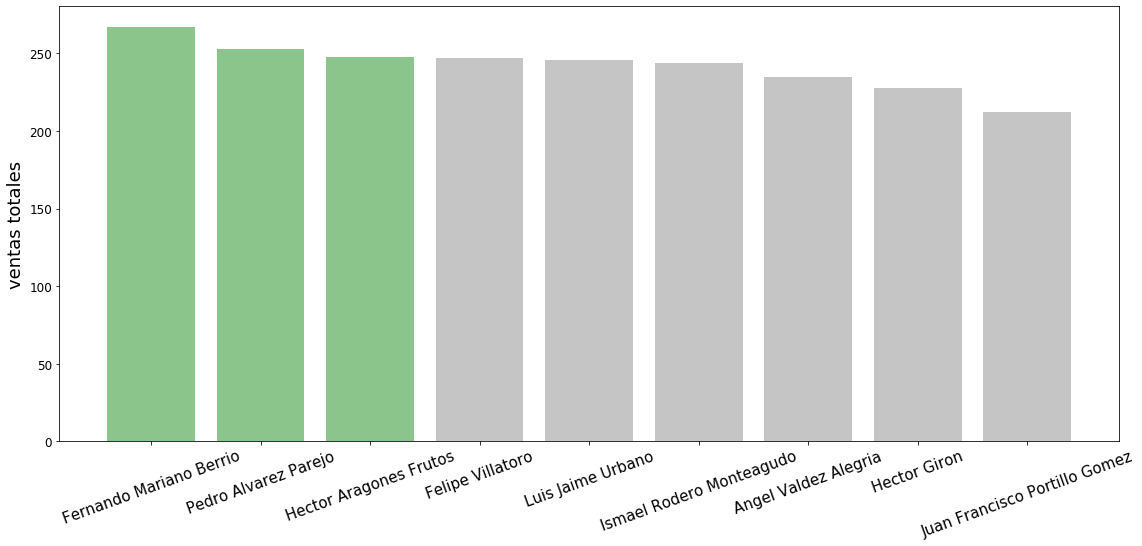

In [28]:
plt.figure(figsize=(19,8))
plt.ylabel("ventas totales",fontsize=18)
plt.xlabel("",fontsize=15)
plt.xticks(rotation=20,fontsize=15)
plt.yticks(fontsize=12)

plt.bar(df_pilotos.sort_values("viajes_totales",ascending=False)["piloto"],
        df_pilotos.sort_values("viajes_totales",ascending=False)["viajes_totales"],
        alpha=0.45,color=["green","green","green","gray","gray","gray","gray","gray","gray"]) #color = ["green","green","green","gray","gray","gray","gray","gray","gray"]

plt.show()

In [37]:
dat.groupby(["piloto","unidad"],as_index=False).agg({"cantidad":["sum"],
                                           "q":["sum","count"]})

piloto          unidad cantidad         q      
                                                       sum       sum count
0            Angel Valdez Alegria   Camion Grande   198048  49512.00   135
1            Angel Valdez Alegria  Camion Pequeño    47056  11764.00    64
2            Angel Valdez Alegria           Panel    12126   3031.50    36
3                Felipe Villatoro   Camion Grande   185833  46458.25   126
4                Felipe Villatoro  Camion Pequeño    57060  14265.00    78
5                Felipe Villatoro           Panel    15613   3903.25    43
6         Fernando Mariano Berrio   Camion Grande   240118  60029.50   157
7         Fernando Mariano Berrio  Camion Pequeño    56354  14088.50    75
8         Fernando Mariano Berrio           Panel    11917   2979.25    35
9          Hector Aragones Frutos   Camion Grande   198703  49675.75   132
10         Hector Aragones Frutos  Camion Pequeño    52613  13153.25    70
11         Hector Aragones Frutos           Panel    15265   3816.25    46
12                   Hector Giron   Camion Grande   186473  46618.25   123
13                   Hector Giron  Camion Pequeño    55101  13775.25    73
14                   Hector Giron           Panel    10247   2561.75    32
15       Ismael Rodero Monteagudo   Camion Grande   228340  57085.00   149
16       Ismael Rodero Monteagudo  Camion Pequeño    41827  10456.75    54
17       Ismael Rodero Monteagudo           Panel    13579   3394.75    41
18  Juan Francisco Portillo Gomez   Camion Grande   178060  44515.00   119
19  Juan Francisco Portillo Gomez  Camion Pequeño    43269  10817.25    58
20  Juan Francisco Portillo Gomez           Panel    12060   3015.00    35
21              Luis Jaime Urbano   Camion Grande   202958  50739.50   136
22              Luis Jaime Urbano  Camion Pequeño    46101  11525.25    64
23              Luis Jaime Urbano           Panel    14910   3727.50    46
24           Pedro Alvarez Parejo   Camion Grande   203333  50833.25   134
25           Pedro Alvarez Parejo  Camion Pequeño    51880  12970.00    69
26           Pedro Alvarez Parejo           Panel    16549   4137.25    50

## Creditos

In [86]:
print(dat.credito.nunique())
print(dat.credito.unique())

3
[30 90 60]


A mis clientes les ofrezco 30,60 y 90 días de credito.

In [36]:
dat.credito.value_counts()

30    771
60    748
90    661
Name: credito, dtype: int64

## Transporte

In [10]:
dat.unidad.unique()

array(['Camion Grande', 'Panel', 'Camion Pequeño'], dtype=object)

Ofrezco 3 tipos de transportes para mis pedidos: Camiones (grandes y pequeños) y paneles.

In [48]:
dat.unidad.value_counts().to_frame().values.ravel()

array([1211,  605,  364], dtype=int64)

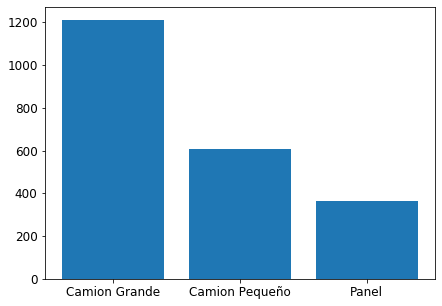

In [62]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,5))
plt.bar(dat.unidad.value_counts().to_frame().index,dat.unidad.value_counts().to_frame().values.ravel())
plt.show()

La mayoria de los viajes se hacen en camion grande.

In [16]:
df_prom_trans = dat.groupby("unidad",as_index=False).agg({"cantidad":"mean"})
df_prom_trans["cantidad"] = df_prom_trans["cantidad"].astype("int")
df_prom_trans

,unidad,cantidad
0,Camion Grande,1504
1,Camion Pequeño,745
2,Panel,335


In [21]:
dat.groupby(["mes","unidad"]).agg({"cantidad":"sum"}).groupby("unidad").agg({"cantidad":"mean"})

,cantidad
unidad,
Camion Grande,165624.181818
Camion Pequeño,41023.727273
Panel,11115.090909


In [22]:
dat.groupby("unidad").agg({"cantidad":"mean"})

,cantidad
unidad,
Camion Grande,1504.431049
Camion Pequeño,745.885950
Panel,335.895604


In [12]:
dat.groupby(["mes","unidad"]).agg({"cantidad":["mean","sum","count"]})

cantidad              
                           mean     sum count
mes unidad                                   
1   Camion Grande   1482.180328  180826   122
    Camion Pequeño   741.860465   31900    43
    Panel            331.111111    8940    27
2   Camion Grande   1516.543860  172886   114
    Camion Pequeño   755.481481   40796    54
    Panel            320.685714   11224    35
3   Camion Grande   1487.877551  145812    98
    Camion Pequeño   746.866667   33609    45
    Panel            370.410256   14446    39
4   Camion Grande   1494.683168  150963   101
    Camion Pequeño   751.881356   44361    59
    Panel            319.611111   11506    36
5   Camion Grande   1519.230769  177750   117
    Camion Pequeño   750.027778   54002    72
    Panel            328.769231    8548    26
6   Camion Grande   1488.112150  159228   107
    Camion Pequeño   732.940000   36647    50
    Panel            329.325000   13173    40
7   Camion Grande   1467.644628  177585   121
    Camion Pequeño   721.795918   35368    49
    Panel            336.048780   13778    41
8   Camion Grande   1538.352941  156912   102
    Camion Pequeño   715.741935   44376    62
    Panel            336.057143   11762    35
9   Camion Grande   1523.578431  155405   102
    Camion Pequeño   734.981481   39689    54
    Panel            343.218750   10983    32
10  Camion Grande   1502.305556  162249   108
    Camion Pequeño   767.047619   48324    63
    Panel            349.827586   10145    29
11  Camion Grande   1531.512605  182250   119
    Camion Pequeño   781.277778   42189    54
    Panel            323.375000    7761    24

## Temporalidad

In [23]:
print("meses:",dat.mes.unique())
print("años:",dat.anio.unique())

meses: [ 1  2  3  4  5  6  7  8  9 10 11]
años: [2019]


Tengo información de casi todo el 2019 con excepcion de Diciembre.

In [45]:
html = dat.credito.value_counts().to_frame().to_html(justify="center",col_space = 25)
html = html.replace('class="dataframe"', 'class="dataframe" align="center"').replace("<td>",'<td align="center">')

with io.open("prueba.html", 'w', encoding='latin') as f:
    f.write(html)

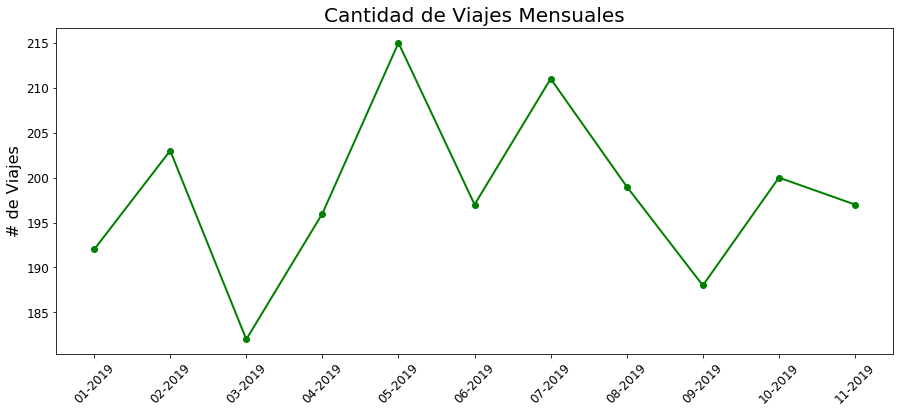

In [101]:
df_ts_count = dat.groupby(["mes_anio"],as_index=False).q.count().sort_values(["mes_anio"])

plt.figure(figsize=(15,6))
plt.plot(df_ts_count["mes_anio"],df_ts_count["q"],linewidth=2,color="green",marker="o")
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.title("Cantidad de Viajes Mensuales",fontsize=20)
plt.ylabel("# de Viajes",fontsize=16)
plt.show()

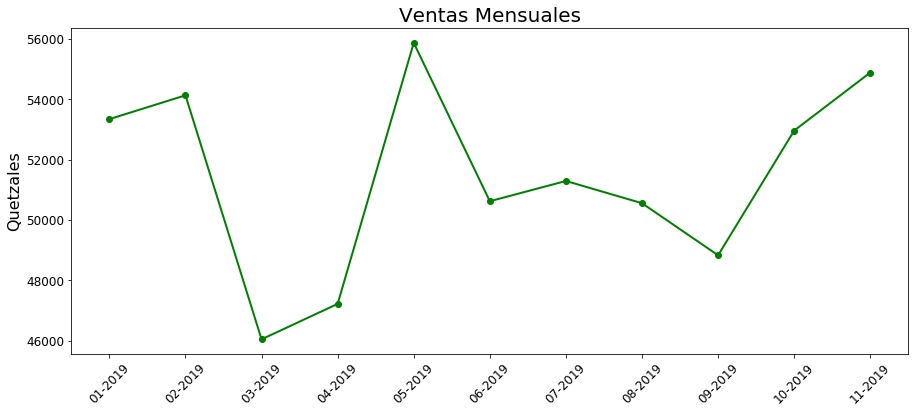

In [38]:
df_ts_sum = dat[~dat["cliente"].str.contains("DEVOLUCION")].groupby(["mes_anio"],as_index=False).q.sum().sort_values(["mes_anio"])

plt.figure(figsize=(15,6))
plt.plot(df_ts_sum["mes_anio"],df_ts_sum["q"],linewidth=2,color="green",marker="o")
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.title("Ventas Mensuales",fontsize=20)
plt.ylabel("Quetzales",fontsize=16)
plt.show()

In [ ]:
#### NOTAS

# Faltante | faltaba de otro pedido
# Devolucion ya no lo querian

## Flujo de Caja

In [91]:
dat.groupby(["cobro","cobro_mes_anio"],as_index=False).q_corregido.sum().sort_values("cobro")

,cobro,cobro_mes_anio,q_corregido
0,2019-02-01,02-2019,20248.50
1,2019-03-01,03-2019,31625.50
2,2019-04-01,04-2019,51978.25
3,2019-05-01,05-2019,44365.75
4,2019-06-01,06-2019,47038.75
5,2019-07-01,07-2019,48332.50
6,2019-08-01,08-2019,48651.25
7,2019-09-01,09-2019,49683.00
8,2019-10-01,10-2019,46844.50
9,2019-11-01,11-2019,44708.50


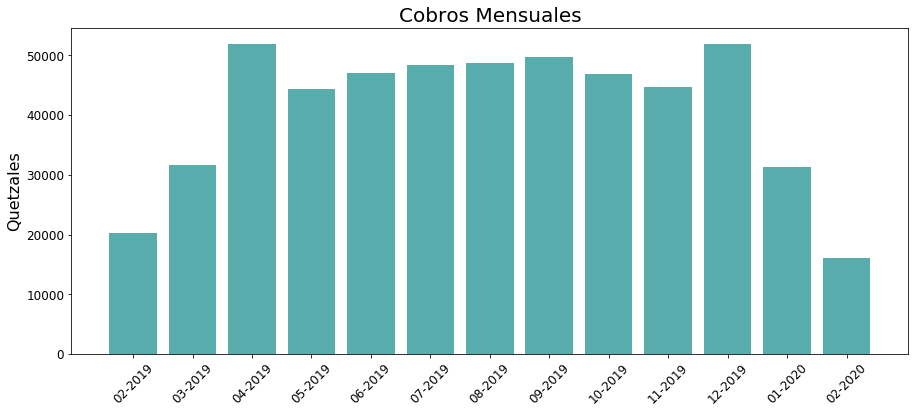

In [12]:
df_liquidez = dat.groupby(["cobro","cobro_mes_anio"],as_index=False).q_corregido.sum().sort_values("cobro")

plt.figure(figsize=(15,6))
plt.bar(df_liquidez["cobro_mes_anio"],df_liquidez["q_corregido"],linewidth=2,color="teal",alpha=0.65)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.title("Cobros Mensuales",fontsize=20)
plt.ylabel("Quetzales",fontsize=16)
plt.show()